In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.feature_selection import SelectKBest, f_classif
import xgboost as xgb

In [ ]:
final_full_data = pd.read_csv("Full_data_features.csv")

In [ ]:
def site_de(x):
    if 'delaware' in x:
        return 'delaware'
    elif '/lu/' in x:
        return 'lu'
    elif 'mandarin' in x:
        return 'china'
    elif 'pitt' in x:
        return 'pitt'
    elif 'spanish' in x:
        return 'spain'
    elif 'ADReSS' in x:
        return "ADReSS"
    elif "TAUKADIAL" in x:
        return "TAUKADIAL"
    else:
        return None
final_full_data['site'] = final_full_data['path'].apply(site_de)


DLData = final_full_data
DLData['uid'] = DLData['ID']
DLData.drop(['ID','Unnamed: 0.1', 'Unnamed: 0', 'processed_path', 'path'], axis=1, inplace=True)
DLData['sex'] = DLData['sex'].fillna(DLData['gender'])
DLData = DLData.dropna(subset=['age', 'sex'])
DLData['sex'] = DLData['sex'].apply(lambda x: 1 if x.lower()[0] == 'm' else 0)
meta = pd.read_csv("additional_metadata.csv")
DLData = DLData.merge(meta[['uid', 'corpus']], on='uid', how='outer')
DLData['site'] = DLData['site'].fillna(DLData['corpus'])
DLData = DLData.drop('corpus', axis=1)
DLData['split'] = DLData['site'].apply(lambda x: 'test' if x == 'pitt' else "train") 
DLData = DLData.dropna(subset=['MCL', 'label'])

DLData[DLData['site'] == 'pitt']

## Multi Classs Classification Normal/MCI/Dementia

In [7]:
# Cell 1: Import Libraries and Prepare Data (Updated for MCL)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Assume DLData is your dataframe

# Define non-feature columns to exclude (updated as per user)
non_feature_cols = ['sex', 'site','mmse', 'label', 'MCL', 'dx', 'language', 'educ',
                    'gender', 'split', 'chunk_index', 'uid']

# Feature columns: all others, including audio features
feature_cols = [col for col in DLData.columns if col not in non_feature_cols]

print(f"Number of features: {len(feature_cols)}")

# Filter train and test data
df_train_full = DLData[DLData['split'] == 'train'].copy()
df_test = DLData[DLData['split'] == 'test'].copy()

# Extract X_test and y_test (using MCL)
X_test = df_test[feature_cols].values
y_test = df_test['MCL'].values

print(f"Test set shape: {X_test.shape}, y_test shape: {y_test.shape}")

Number of features: 2166
Test set shape: (360, 2166), y_test shape: (360,)


Train shape: (2994, 2166), y_train shape: (2994,)
Val shape: (771, 2166), y_val shape: (771,)


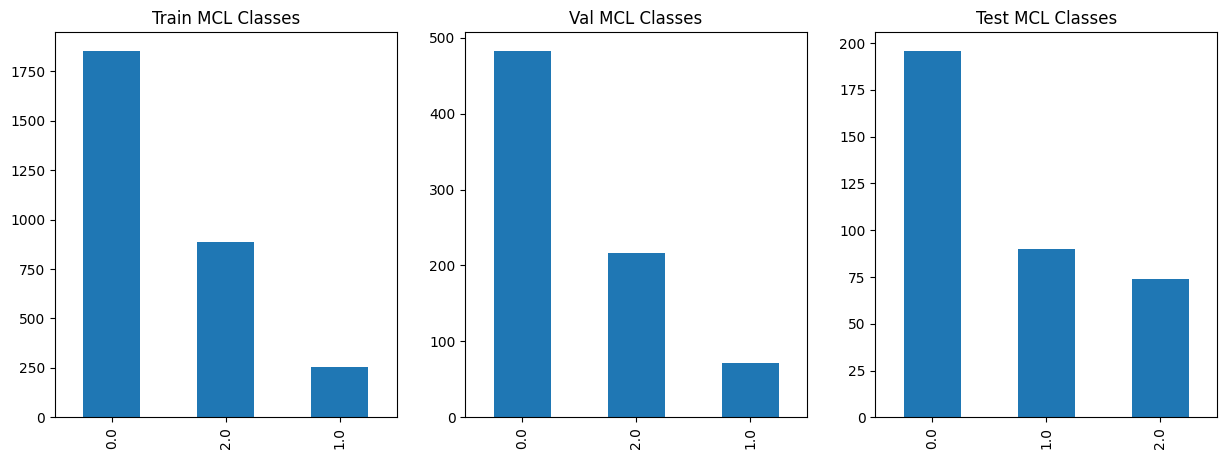

UID overlap between train and val: 0


In [8]:
# Cell 2: Grouped Split by UID to Prevent Leakage (Updated for MCL)
# Get unique uids from train_full
unique_uids = df_train_full['uid'].unique()

# Split uids into train and val (80/20, random state for reproducibility)
train_uids, val_uids = train_test_split(unique_uids, test_size=0.2, random_state=42)

# Create train and val dataframes based on uids
df_train = df_train_full[df_train_full['uid'].isin(train_uids)]
df_val = df_train_full[df_train_full['uid'].isin(val_uids)]

# Extract X_train, y_train, X_val, y_val (using MCL)
X_train = df_train[feature_cols].values
y_train = df_train['MCL'].values

X_val = df_val[feature_cols].values
y_val = df_val['MCL'].values

print(f"Train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"Val shape: {X_val.shape}, y_val shape: {y_val.shape}")

# Visualize class distribution
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(15,5))
pd.Series(y_train).value_counts().plot(kind='bar', ax=axs[0])
axs[0].set_title('Train MCL Classes')
pd.Series(y_val).value_counts().plot(kind='bar', ax=axs[1])
axs[1].set_title('Val MCL Classes')
pd.Series(y_test).value_counts().plot(kind='bar', ax=axs[2])
axs[2].set_title('Test MCL Classes')
plt.show()

# Verify no UID overlap
train_uid_set = set(df_train['uid'].unique())
val_uid_set = set(df_val['uid'].unique())
overlap = train_uid_set & val_uid_set
print(f"UID overlap between train and val: {len(overlap)}")

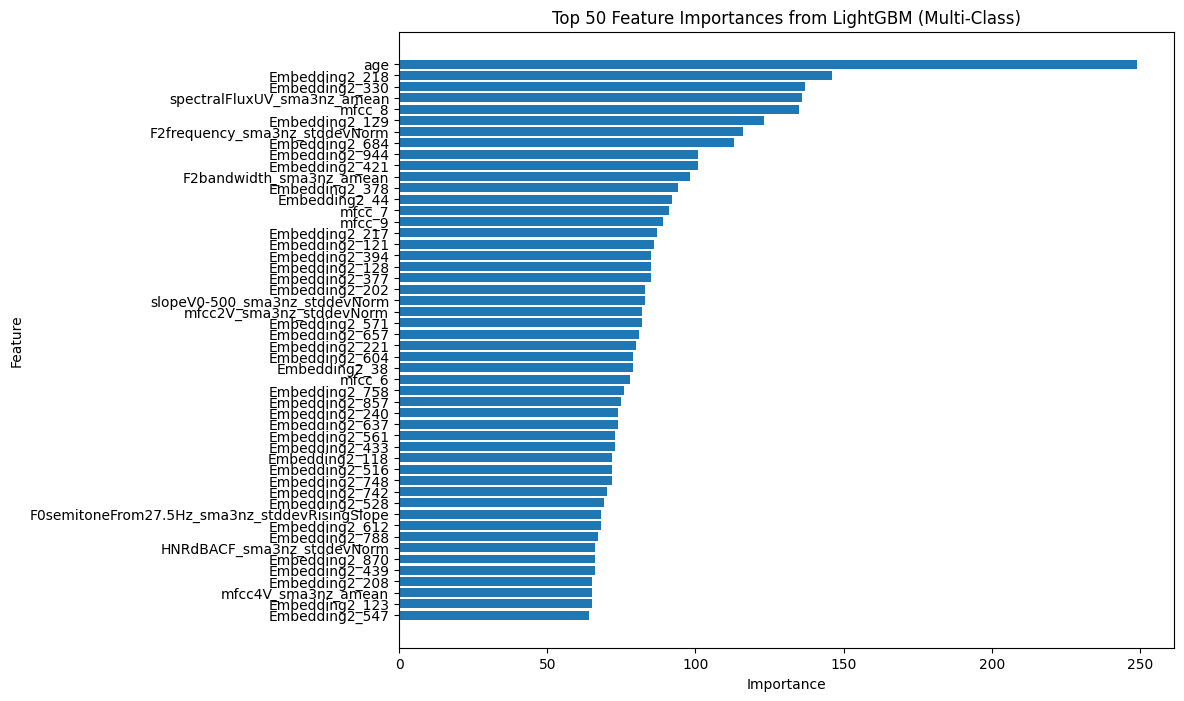

Top 10 Features by Importance:
                            Feature  Importance
0                               age         249
1359                 Embedding2_218         146
1471                 Embedding2_330         137
81      spectralFluxUV_sma3nz_amean         136
96                           mfcc_8         135
1270                 Embedding2_129         123
48    F2frequency_sma3nz_stddevNorm         116
1825                 Embedding2_684         113
2085                 Embedding2_944         101
1562                 Embedding2_421         101
Reduced shapes: Train (2994, 500), Val (771, 500), Test (360, 500)


In [9]:
# Cell 3: LightGBM for Feature Importance and Selection (Multi-Class)
import lightgbm as lgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Train LightGBM for multi-class feature importances
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'device': 'gpu',
    'verbose': -1,
    'random_state': 42
}

train_data = lgb.Dataset(X_train, label=y_train)
model_lgb_imp = lgb.train(params, train_data, num_boost_round=1000)

# Get feature importances
importances = model_lgb_imp.feature_importance(importance_type='split')
feature_names = feature_cols

imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
imp_df = imp_df.sort_values(by='Importance', ascending=False)

# Visualize top 50
top_n = 50
plt.figure(figsize=(10, 8))
plt.barh(imp_df['Feature'][:top_n], imp_df['Importance'][:top_n])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 50 Feature Importances from LightGBM (Multi-Class)')
plt.gca().invert_yaxis()
plt.show()

print("Top 10 Features by Importance:")
print(imp_df.head(10))

# Select top 500 features
n_select = 500
selected_features = imp_df['Feature'][:n_select].tolist()
selected_indices = [feature_cols.index(f) for f in selected_features]

X_train_sel = X_train[:, selected_indices]
X_val_sel = X_val[:, selected_indices]
X_test_sel = X_test[:, selected_indices]

print(f"Reduced shapes: Train {X_train_sel.shape}, Val {X_val_sel.shape}, Test {X_test_sel.shape}")

LGBM Validation Metrics: {'Accuracy': 0.7704280155642024, 'Log Loss': 1.341871636753749, 'AUC (ovr)': np.float64(0.8743246368434267), 'Precision_0': np.float64(0.768581081081081), 'Recall_0': np.float64(0.9420289855072463), 'F1_0': np.float64(0.8465116279069768), 'Specificity_0': np.float64(0.5243055555555556), 'Precision_1': np.float64(0.6818181818181818), 'Recall_1': np.float64(0.20833333333333334), 'F1_1': np.float64(0.3191489361702128), 'Specificity_1': np.float64(0.9899856938483548), 'Precision_2': np.float64(0.7898089171974523), 'Recall_2': np.float64(0.5740740740740741), 'F1_2': np.float64(0.6648793565683646), 'Specificity_2': np.float64(0.9405405405405406)}
LGBM Test Metrics: {'Accuracy': 0.5833333333333334, 'Log Loss': 3.5887560805694387, 'AUC (ovr)': np.float64(0.6584734067186642), 'Precision_0': np.float64(0.6073825503355704), 'Recall_0': np.float64(0.923469387755102), 'F1_0': np.float64(0.7327935222672065), 'Specificity_0': np.float64(0.2865853658536585), 'Precision_1': np.

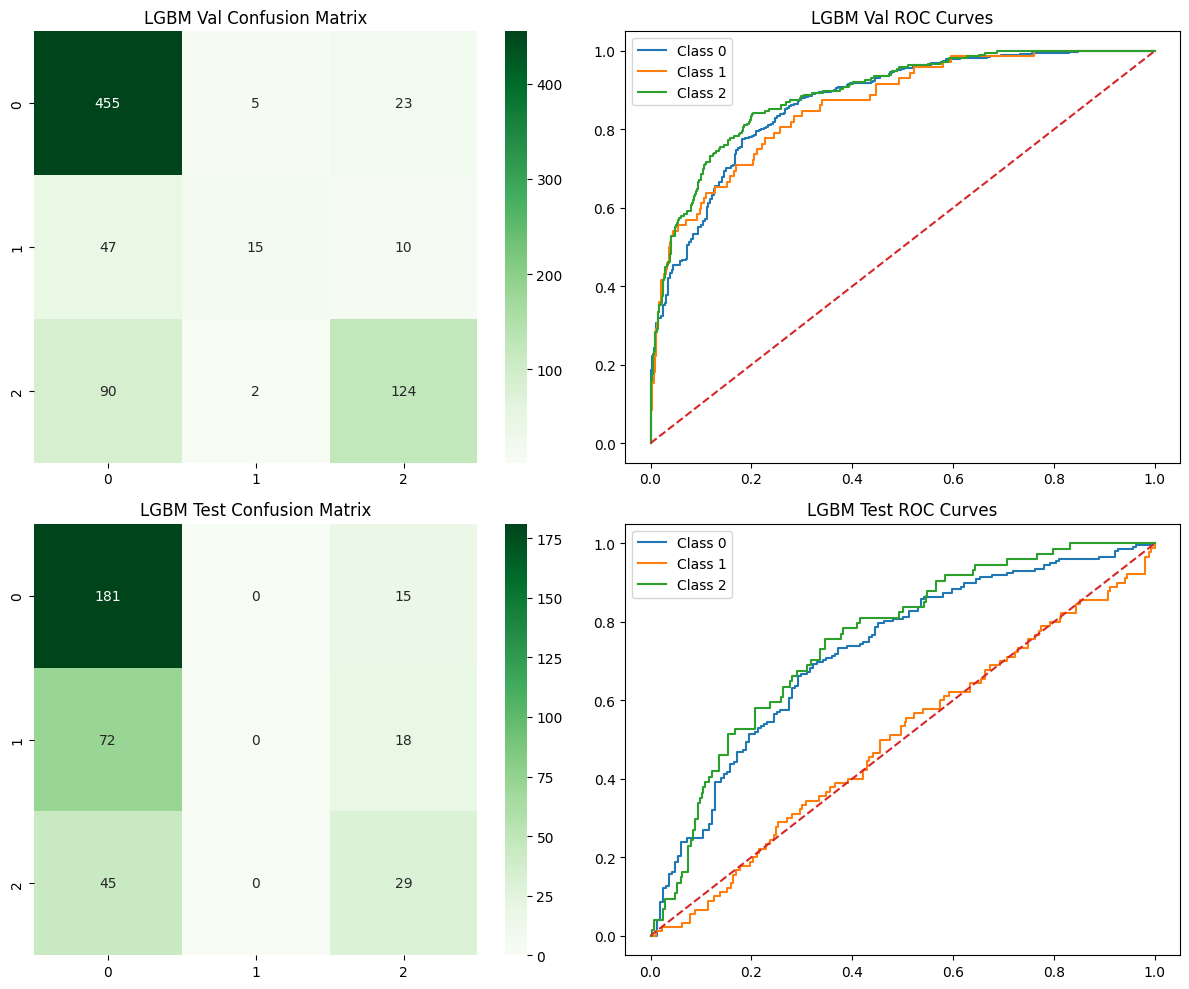

In [10]:
# Cell 4: LGBM Multi-Class Training, Validation, and Test with Metrics
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support, log_loss
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize

# Train LGBM for multi-class
params = {
    'objective': 'multiclass',
    'num_class': 3,
    'metric': 'multi_logloss',
    'device': 'gpu',
    'verbose': -1,
    'random_state': 42
}

train_data = lgb.Dataset(X_train_sel, label=y_train)
val_data = lgb.Dataset(X_val_sel, label=y_val, reference=train_data)

model_lgb = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[val_data])

# Function to compute multi-class metrics
def compute_multi_metrics(y_true, y_pred, y_prob, prefix):
    acc = accuracy_score(y_true, y_pred)
    logloss = log_loss(y_true, y_prob)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, zero_division=0)
    auc_ovr = roc_auc_score(y_true, y_prob, multi_class='ovr') if len(np.unique(y_true)) > 1 else np.nan
    conf = confusion_matrix(y_true, y_pred)
    
    # Per class specificity: for each class, TN / (TN + FP)
    specificity = []
    for i in range(3):
        tn = conf.sum() - (conf[i, :].sum() + conf[:, i].sum() - conf[i, i])
        fp = conf[:, i].sum() - conf[i, i]
        specificity.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
    
    # ROC curves (one-vs-rest)
    y_true_bin = label_binarize(y_true, classes=[0,1,2])
    fpr = dict()
    tpr = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    
    return {
        'Accuracy': acc,
        'Log Loss': logloss,
        'AUC (ovr)': auc_ovr,
        'Precision_0': prec[0], 'Recall_0': rec[0], 'F1_0': f1[0], 'Specificity_0': specificity[0],
        'Precision_1': prec[1], 'Recall_1': rec[1], 'F1_1': f1[1], 'Specificity_1': specificity[1],
        'Precision_2': prec[2], 'Recall_2': rec[2], 'F1_2': f1[2], 'Specificity_2': specificity[2]
    }, conf, fpr, tpr

# Validation
y_prob_val = model_lgb.predict(X_val_sel)
y_pred_val = np.argmax(y_prob_val, axis=1)
metrics_val, conf_val, fpr_val, tpr_val = compute_multi_metrics(y_val, y_pred_val, y_prob_val, 'Val')

# Test
y_prob_test = model_lgb.predict(X_test_sel)
y_pred_test = np.argmax(y_prob_test, axis=1)
metrics_test, conf_test, fpr_test, tpr_test = compute_multi_metrics(y_test, y_pred_test, y_prob_test, 'Test')

# Print metrics
print("LGBM Validation Metrics:", metrics_val)
print("LGBM Test Metrics:", metrics_test)

# Create tables
metrics_df_val = pd.DataFrame([metrics_val])
metrics_df_test = pd.DataFrame([metrics_test])
print("LGBM Validation Table:")
print(metrics_df_val.T)
print("LGBM Test Table:")
print(metrics_df_test.T)

# Visualizations
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Val Confusion
sns.heatmap(conf_val, annot=True, fmt='d', cmap='Greens', ax=axs[0, 0])
axs[0, 0].set_title('LGBM Val Confusion Matrix')

# Val ROC (multi-class)
for i in range(3):
    axs[0, 1].plot(fpr_val[i], tpr_val[i], label=f'Class {i}')
axs[0, 1].plot([0,1],[0,1],'--')
axs[0, 1].set_title('LGBM Val ROC Curves')
axs[0, 1].legend()

# Test Confusion
sns.heatmap(conf_test, annot=True, fmt='d', cmap='Greens', ax=axs[1, 0])
axs[1, 0].set_title('LGBM Test Confusion Matrix')

# Test ROC
for i in range(3):
    axs[1, 1].plot(fpr_test[i], tpr_test[i], label=f'Class {i}')
axs[1, 1].plot([0,1],[0,1],'--')
axs[1, 1].set_title('LGBM Test ROC Curves')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Cell 5: GBM Multi-Class Training, Validation, and Test with Metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support, log_loss
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize

# Train GBM
model_gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model_gbm.fit(X_train_sel, y_train)

# Use same compute_multi_metrics function

# Validation
y_prob_val = model_gbm.predict_proba(X_val_sel)
y_pred_val = model_gbm.predict(X_val_sel)
metrics_val, conf_val, fpr_val, tpr_val = compute_multi_metrics(y_val, y_pred_val, y_prob_val, 'Val')

# Test
y_prob_test = model_gbm.predict_proba(X_test_sel)
y_pred_test = model_gbm.predict(X_test_sel)
metrics_test, conf_test, fpr_test, tpr_test = compute_multi_metrics(y_test, y_pred_test, y_prob_test, 'Test')

# Print metrics
print("GBM Validation Metrics:", metrics_val)
print("GBM Test Metrics:", metrics_test)

# Create tables
metrics_df_val = pd.DataFrame([metrics_val])
metrics_df_test = pd.DataFrame([metrics_test])
print("GBM Validation Table:")
print(metrics_df_val.T)
print("GBM Test Table:")
print(metrics_df_test.T)

# Visualizations (same as above)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

sns.heatmap(conf_val, annot=True, fmt='d', cmap='Purples', ax=axs[0, 0])
axs[0, 0].set_title('GBM Val Confusion Matrix')

for i in range(3):
    axs[0, 1].plot(fpr_val[i], tpr_val[i], label=f'Class {i}')
axs[0, 1].plot([0,1],[0,1],'--')
axs[0, 1].set_title('GBM Val ROC Curves')
axs[0, 1].legend()

sns.heatmap(conf_test, annot=True, fmt='d', cmap='Purples', ax=axs[1, 0])
axs[1, 0].set_title('GBM Test Confusion Matrix')

for i in range(3):
    axs[1, 1].plot(fpr_test[i], tpr_test[i], label=f'Class {i}')
axs[1, 1].plot([0,1],[0,1],'--')
axs[1, 1].set_title('GBM Test ROC Curves')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

TabPFN Validation Metrics: {'Accuracy': 0.7561608300907912, 'Log Loss': 0.5671964017723512, 'AUC (ovr)': np.float64(0.8773634037060308), 'Precision_0': np.float64(0.7520525451559934), 'Recall_0': np.float64(0.94824016563147), 'F1_0': np.float64(0.8388278388278388), 'Specificity_0': np.float64(0.4756944444444444), 'Precision_1': np.float64(0.782608695652174), 'Recall_1': np.float64(0.25), 'F1_1': np.float64(0.37894736842105264), 'Specificity_1': np.float64(0.9928469241773963), 'Precision_2': np.float64(0.7697841726618705), 'Recall_2': np.float64(0.49537037037037035), 'F1_2': np.float64(0.6028169014084507), 'Specificity_2': np.float64(0.9423423423423424)}
TabPFN Test Metrics: {'Accuracy': 0.5777777777777777, 'Log Loss': 1.1041995825737498, 'AUC (ovr)': np.float64(0.6682882430004639), 'Precision_0': np.float64(0.5974025974025974), 'Recall_0': np.float64(0.9387755102040817), 'F1_0': np.float64(0.7301587301587301), 'Specificity_0': np.float64(0.24390243902439024), 'Precision_1': np.float64(

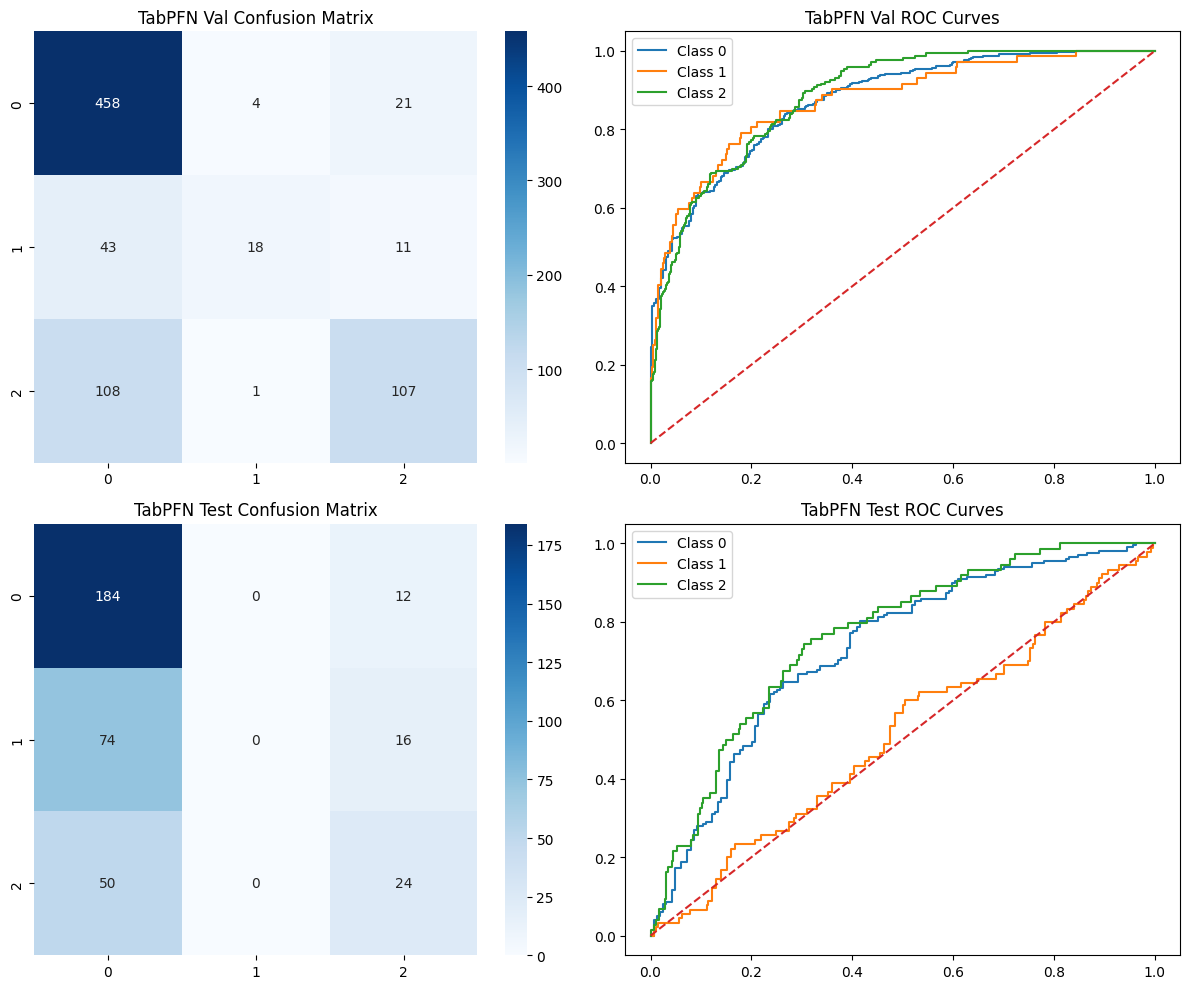

In [12]:
# Cell 6: TabPFN Multi-Class Training, Validation, and Test with Metrics
# Install if needed: !pip install tabpfn
from tabpfn import TabPFNClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support, log_loss
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize

# Initialize TabPFN
model_tabpfn = TabPFNClassifier(device='cuda:0')

# Fit
model_tabpfn.fit(X_train_sel, y_train)

# Use same compute_multi_metrics function

# Validation
y_prob_val = model_tabpfn.predict_proba(X_val_sel)
y_pred_val = model_tabpfn.predict(X_val_sel)
metrics_val, conf_val, fpr_val, tpr_val = compute_multi_metrics(y_val, y_pred_val, y_prob_val, 'Val')

# Test
y_prob_test = model_tabpfn.predict_proba(X_test_sel)
y_pred_test = model_tabpfn.predict(X_test_sel)
metrics_test, conf_test, fpr_test, tpr_test = compute_multi_metrics(y_test, y_pred_test, y_prob_test, 'Test')

# Print metrics
print("TabPFN Validation Metrics:", metrics_val)
print("TabPFN Test Metrics:", metrics_test)

# Create tables
metrics_df_val = pd.DataFrame([metrics_val])
metrics_df_test = pd.DataFrame([metrics_test])
print("TabPFN Validation Table:")
print(metrics_df_val.T)
print("TabPFN Test Table:")
print(metrics_df_test.T)

# Visualizations (same as above)
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

sns.heatmap(conf_val, annot=True, fmt='d', cmap='Blues', ax=axs[0, 0])
axs[0, 0].set_title('TabPFN Val Confusion Matrix')

for i in range(3):
    axs[0, 1].plot(fpr_val[i], tpr_val[i], label=f'Class {i}')
axs[0, 1].plot([0,1],[0,1],'--')
axs[0, 1].set_title('TabPFN Val ROC Curves')
axs[0, 1].legend()

sns.heatmap(conf_test, annot=True, fmt='d', cmap='Blues', ax=axs[1, 0])
axs[1, 0].set_title('TabPFN Test Confusion Matrix')

for i in range(3):
    axs[1, 1].plot(fpr_test[i], tpr_test[i], label=f'Class {i}')
axs[1, 1].plot([0,1],[0,1],'--')
axs[1, 1].set_title('TabPFN Test ROC Curves')
axs[1, 1].legend()

plt.tight_layout()
plt.show()